In [1]:
import torch
    
import sns_toolbox
from sns_toolbox.connections import NonSpikingPatternConnection
from sns_toolbox.networks import Network
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sys
from matplotlib.animation import FuncAnimation


from conductance_network import GsynModule, ConductanceLayerMulti, ConductanceNetwork

(-0.5, 31.5, 31.5, -0.5)

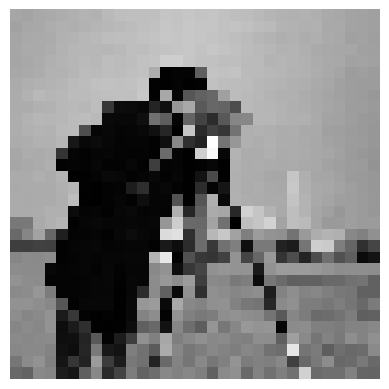

In [2]:
#dirname = os.path.dirname(__file__)
#filename = os.path.join(dirname, 'relative/path/to/file/you/want')

img = cv.imread('cameraman.png')   # load image file

if img is None:
    sys.exit('Could not find image')
shape_original = img.shape  # dimensions of the original image
dim_long = max(shape_original[0],shape_original[1]) # longest dimension of the original image
dim_desired_max = 32    # constrain the longest dimension for easier processing
ratio = dim_desired_max/dim_long    # scaling ratio of original image
img_resized = cv.resize(img,None,fx=ratio,fy=ratio) # scale original image using ratio

img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # transform the image from BGR to RGB
img_color_resized = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)  # resize the RGB image
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)  # convert the resized image to grayscale [0-255]

shape = img_gray.shape  # dimensions of the resized grayscale image

img_flat = img_gray.flatten()   # flatten the image into 1 vector for neural processing
flat_size = len(img_flat)   # length of the flattened image vector

plt.figure()
plt.imshow(img_gray,cmap='gray')
plt.axis('off')

## Making the SNS Toolbox Model


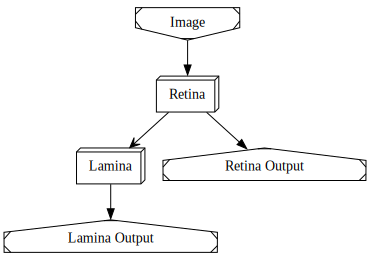

In [3]:
# General network
R = 20.0    # range of network activity (mV)
neuron_type = NonSpikingNeuron()    # generic neuron type
net = Network(name='Visual Network')    # create an empty network

# Retina
net.add_population(neuron_type,shape,name='Retina') # add a 2d population the same size as the scaled image
net.add_input('Retina', size=flat_size,name='Image')    # add a vector input for the flattened scaled image
net.add_output('Retina',name='Retina Output')  # add a vector output from the retina, scaled correctly

# Lamina
net.add_population(neuron_type,shape,name='Lamina')

del_e_ex = 160.0    # excitatory reversal potential
del_e_in = -80.0    # inhibitory reversal potential
k_ex = 1.0  # excitatory gain
k_in = -1.0/9.0 # inhibitory gain
g_max_ex = (k_ex*R)/(del_e_ex-k_ex*R)   # calculate excitatory conductance
g_max_in = (k_in*R)/(del_e_in-k_in*R)   # calculate inhibitory conductance

g_max_kernel = np.array([[g_max_in, g_max_in, g_max_in],    # kernel matrix of synaptic conductances
                         [g_max_in, g_max_ex, g_max_in],
                         [g_max_in, g_max_in, g_max_in]])
del_e_kernel = np.array([[del_e_in, del_e_in, del_e_in],    # kernel matrix of synaptic reversal potentials
                         [del_e_in, del_e_ex, del_e_in],
                         [del_e_in, del_e_in, del_e_in]])
e_lo_kernel = np.zeros([3,3])
e_hi_kernel = np.zeros([3,3]) + R
connection_hpf = NonSpikingPatternConnection(g_max_kernel,del_e_kernel,e_lo_kernel,e_hi_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_hpf,'Retina','Lamina',name='HPF') # connect the retina to the lamina
net.add_output('Lamina',name='Lamina Output')  # add a vector output from the lamina

img_flat = img_flat*R/255.0 # scale all the intensities from 0-255 to 0-R
render(net)

In [4]:
neuron_type.params

{'membrane_capacitance': 5.0,
 'membrane_conductance': 1.0,
 'resting_potential': 0.0,
 'bias': 0.0,
 'spiking': False,
 'gated': False}

In [15]:
comp = net.compile(dt=0.01,backend='torch')

In [16]:
# New ConductanceNetwork Construction
dt = 0.01 #torch.ones(shape[0], dtype=torch.double)
C_mem = comp.c_m #torch.rand(shape[0], dtype=torch.double)
G_mem = comp.g_m #torch.rand(shape[0], dtype=torch.double)
b_mem = comp.i_b #torch.rand(shape[0], dtype=torch.double)
Esyn = comp.del_e #torch.randn(shape, dtype=torch.double)
network_shape = [1024,1024]
# Retina layer
retina_dt = dt * torch.ones(network_shape[0], dtype=torch.double)
retina_C_mem = torch.ones(network_shape[0], dtype=torch.double)*5
retina_G_mem = torch.ones(network_shape[0], dtype=torch.double)
retina_b_mem = torch.zeros(network_shape[0], dtype=torch.double)
retina_Esyn = torch.zeros(network_shape, dtype=torch.double)
retina_Gsyn = lambda x: torch.zeros_like(x, dtype=torch.double)
retina_layer = ConductanceLayerMulti(n_prev=flat_size, n=flat_size,
                                     dt=retina_dt, C_mem=retina_C_mem,
                                     G_mem=retina_G_mem, b_mem=retina_b_mem,
                                     Esyn_self=retina_Esyn, Gsyn_self=retina_Gsyn, is_first=True)

layer_Esyn = torch.tensor(sns_toolbox.networks.__kernel_connections_2d__(shape,del_e_kernel,fill_value=0.0))
layer_Gsyn = lambda x: 1 / R * torch.clamp(x, min=0, max=R) * torch.tensor(sns_toolbox.networks.__kernel_connections_2d__(shape,g_max_kernel,fill_value=0.0))

# Lamina layer
lamina_dt = dt * torch.ones(network_shape[0], dtype=torch.double)
lamina_C_mem = torch.ones(network_shape[0], dtype=torch.double)*5
lamina_G_mem = torch.ones(network_shape[0], dtype=torch.double)
lamina_b_mem = torch.zeros(network_shape[0], dtype=torch.double)
lamina_Esyn = torch.zeros(network_shape, dtype=torch.double)
lamina_Gsyn = lambda x: torch.zeros_like(x, dtype=torch.double)
lamina_layer = ConductanceLayerMulti(n_prev=flat_size, n=flat_size,
                                     dt=lamina_dt, C_mem=lamina_C_mem,
                                     G_mem=lamina_G_mem, b_mem=lamina_b_mem,
                                     Esyn_self=lamina_Esyn, Gsyn_self=lamina_Gsyn,
                                     Esyn_prev=layer_Esyn, Gsyn_prev=layer_Gsyn)


# Construct the ConductanceNetwork
layers = [retina_layer, lamina_layer]
network = ConductanceNetwork(layers)
print(lamina_dt)

tensor([0.0100, 0.0100, 0.0100,  ..., 0.0100, 0.0100, 0.0100],
       dtype=torch.float64)


In [17]:
will_state = comp(torch.tensor(img_flat,dtype=torch.float))
ben_state = network(torch.tensor(img_flat,dtype=torch.double))
will_state = will_state.detach().numpy()[1024:]
ben_state = ben_state.detach().numpy()
#
assert np.allclose(will_state, ben_state, atol=1e-3), "Network states do not match" #uhoh

In [24]:
img_shape = (32,32)
t_max = 5
steps = int(t_max)
print(steps)

5


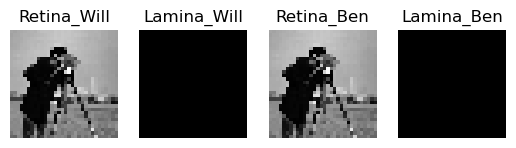

In [25]:

network = ConductanceNetwork(layers)
comp = net.compile(dt=dt,backend='torch')

ben_retina_data = []
ben_lamina_data = []
will_retina_data = []
will_lamina_data = []


for i in range(steps):
       
    
    will_out = comp(torch.tensor(img_flat,dtype=torch.float))   # run the network for one dt
    will_retina = will_out[:flat_size].detach().numpy()    # separate the retina and lamina states
    will_lamina = will_out[flat_size:].detach().numpy()
    will_retina_reshape = np.reshape(will_retina,img_shape)   # reshape to from flat to an image
    will_lamina_reshape = np.reshape(will_lamina,img_shape)
    will_retina_data.append(will_retina_reshape)
    will_lamina_data.append(will_lamina_reshape)
    
    
    
    ben_out = network(torch.tensor(img_flat,dtype=torch.double))   # run the network for one dt
    ben_retina = network.current_states[0].detach().numpy()  # separate the retina and lamina states
    ben_lamina = ben_out.detach().numpy()
    ben_retina_reshape = np.reshape(ben_retina,img_shape)   # reshape to from flat to an image
    ben_lamina_reshape = np.reshape(ben_lamina,img_shape)
    ben_retina_data.append(ben_retina_reshape)
    ben_lamina_data.append(ben_lamina_reshape)
 
 
fig = plt.figure()
 # Function to update the animation
def update(frame):
    plt.subplot(1, 4, 1)
    plt.imshow(will_retina_data[frame], cmap='gray')
    plt.title('Retina_Will')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(will_lamina_data[frame], cmap='gray')
    plt.title('Lamina_Will')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(ben_retina_data[frame], cmap='gray')
    plt.title('Retina_Ben')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(ben_lamina_data[frame], cmap='gray')
    plt.title('Lamina_Ben')
    plt.axis('off')

# Create the figure for the animation

# Create the animation
ani = FuncAnimation(fig, update, frames=steps, repeat=False)

# To display the animation
#plt.show()
ani.save('test.gif', writer='imagemagick', fps=10)
from IPython.display import HTML
HTML(ani.to_jshtml())
#plt.close()

In [13]:
print(layer_Gsyn.G_scale.shape)
print(comp.g_max_non[1024:,1024:].shape)

print(layer_Gsyn.G_scale == comp.g_max_non[1024:,:1024])


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(layer_Gsyn.G_scale.detach().numpy())
axs[0].set_title('layer_Gsyn.G_scale')
axs[1].imshow( comp.g_max_non[1024:,:1024].detach().numpy())
axs[1].set_title('comp.g_max_non')
plt.show()

print(layer_Gsyn.G_scale[:4,:4])
print(comp.g_max_non[1024:,:1024][:4,:4])
print(comp.g_max_non.dtype)
assert np.allclose(layer_Gsyn.G_scale.detach().numpy(), comp.g_max_non[1024:,:1024].detach().numpy(), atol=1e-3), "G_scale does not match"


AttributeError: 'function' object has no attribute 'G_scale'

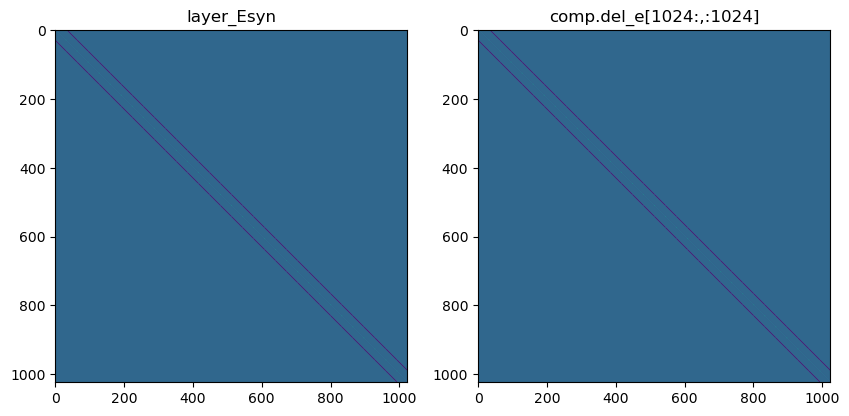

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(layer_Esyn.detach().numpy())
axs[0].set_title('layer_Esyn')
axs[1].imshow( comp.del_e[1024:,:1024].detach().numpy())
axs[1].set_title('comp.del_e[1024:,:1024]')
plt.show()
assert np.allclose(layer_Esyn.detach().numpy(), comp.del_e[1024:,:1024].detach().numpy(), atol=1e-3), "Esyn does not match"